In [1]:
import os
import sys
from pathlib import Path

sys.path.insert(1, os.path.join(sys.path[0], '..'))
import Dataloader_mmd_ce

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter



import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
window_size = 1024
overlap_size = 0
vel_cut_off_value = 0
#features_of_interest = ['S:x_bottom', 'S:y_bottom', 'S:z_bottom', 'S:x_nut', 'S:y_nut', 'S:z_nut', 'S:x_top', 'S:y_top', 'S:z_top', 'S:Nominal_rotational_speed[rad/s]', 'S:Actual_rotational_speed[µm/s]', 'S:Actual_position_of_the_position_encoder(dy/dt)[µm/s]', 'S:Actual_position_of_the_motor_encoder(dy/dt)[µm/s]']
features_of_interest = ['C:x_bottom', 'C:y_bottom', 'C:z_bottom']

list_of_source_BSD_states = ["2", "3", "11", "12", "20", "21"]
list_of_target_BSD_states = ["5", "6", "14", "15", "23", "24"]
data_path = Path(os.getcwd()).parents[1]
data_path = os.path.join(data_path, "data")
dataloader_split_ce = 0.6
dataloader_split_mmd = 0.2
dataloader_split_val = 0.2
batch_size = 32

source_loader = Dataloader_mmd_ce.create_dataloader(data_path, list_of_source_BSD_states, window_size, overlap_size, features_of_interest, dataloader_split_ce, dataloader_split_mmd, dataloader_split_val, batch_size)
target_loader = Dataloader_mmd_ce.create_dataloader(data_path, list_of_target_BSD_states, window_size, overlap_size, features_of_interest, dataloader_split_ce, dataloader_split_mmd, dataloader_split_val, batch_size)


/Users/fabiankolb/Documents/Universität/TUM_Master/Masterarbeit/CODE/DA_TL_FOR_PM/DOMAIN_ADAPTION/Dataloader_mmd_ce.py:38: UserWarning: Not all elements were covered
  warnings.warn("Not all elements were covered")


1/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/046_2020_04_23.csv
Shape of collected datafram: X_shape: (73, 3, 1024), Y_shape: (73,)
2/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/037_2020_04_23.csv
Shape of collected datafram: X_shape: (146, 3, 1024), Y_shape: (146,)
3/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/041_2020_04_23.csv
Shape of collected datafram: X_shape: (219, 3, 1024), Y_shape: (219,)
4/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/038_2020_04_23.csv
Shape of collected datafram: X_shape: (292, 3, 1024), Y_shape: (292,)
5/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/039_2020_04_23.csv
Shape of collected datafram: X_shape: (365, 3, 1024), Y_shape: (365,)
6/60 folders downloaded
downloaded folder: NR02_20200423_PGS_31_BSD_21/040_2020_04_23.csv
Shape of collected datafram: X_shape: (438, 3, 1024), Y_shape: (438,)
7/60 folders downloaded
downloaded folder:

52/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/249_2020_05_08.csv
Shape of collected datafram: X_shape: (3796, 3, 1024), Y_shape: (3796,)
53/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/246_2020_05_08.csv
Shape of collected datafram: X_shape: (3869, 3, 1024), Y_shape: (3869,)
54/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/247_2020_05_08.csv
Shape of collected datafram: X_shape: (3942, 3, 1024), Y_shape: (3942,)
55/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/248_2020_05_08.csv
Shape of collected datafram: X_shape: (4015, 3, 1024), Y_shape: (4015,)
56/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/240_2020_05_08.csv
Shape of collected datafram: X_shape: (4088, 3, 1024), Y_shape: (4088,)
57/60 folders downloaded
downloaded folder: NR21_20200508_PGS_11_BSD_11/242_2020_05_08.csv
Shape of collected datafram: X_shape: (4161, 3, 1024), Y_shape: (4161,)
58/60 folders download

43/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/289_2020_05_11.csv
Shape of collected datafram: X_shape: (3139, 3, 1024), Y_shape: (3139,)
44/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/294_2020_05_11.csv
Shape of collected datafram: X_shape: (3212, 3, 1024), Y_shape: (3212,)
45/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/286_2020_05_11.csv
Shape of collected datafram: X_shape: (3285, 3, 1024), Y_shape: (3285,)
46/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/293_2020_05_11.csv
Shape of collected datafram: X_shape: (3358, 3, 1024), Y_shape: (3358,)
47/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/292_2020_05_11.csv
Shape of collected datafram: X_shape: (3431, 3, 1024), Y_shape: (3431,)
48/60 folders downloaded
downloaded folder: NR23_20200511_PGS_11_BSD_22/287_2020_05_11.csv
Shape of collected datafram: X_shape: (3504, 3, 1024), Y_shape: (3504,)
49/60 folders download

In [34]:
class CNN(nn.Module):
    def __init__(self, input_size, input_fc_size, hidden_fc_size_1):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: ((1024+2*0-(100-1)-1)/1)+1 = 925
        self.pool1 = nn.MaxPool1d(4, stride=3) #((925+2*0-1*(4-1)-1)/3)+1 = 308
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: ((308+2*1-(10-1)-1)/1)+1 = 301
        self.batch1 =nn.BatchNorm1d(32) #301
        self.pool2 = nn.MaxPool1d(4, stride=3) #((301+2*0-1*(4-1)-1)/3)+1 = 100
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #((301+2*1-(5-1)-1)/1)+1 = 299
        self.batch2 =nn.BatchNorm1d(32) #299
        #self.pool3 = nn.MaxPool1d(5, stride=3) #((98+2*0-1*(5-1)-1)/3)+1 = 32
        self.fc1 = nn.Linear(input_fc_size, hidden_fc_size_1)
    
    def forward(self, x):
        x_conv_1 = self.conv1(x) #conv1
        x = F.relu(x_conv_1) #relu
        x = self.pool1(x) #pool1
        x_conv_2 = self.conv2(x) #conv2
        x = self.batch1(x_conv_2) #batch1
        x = F.relu(x) #relu
        #x = self.pool2(x) #pool2
        x_conv_3 = self.conv3(x) #conv3
        x = self.batch2(x_conv_3) #batch2
        x = F.relu(x) #relu
        #x = self.pool3(x) #pool3
        x_flatten = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        x_normalize = torch.nn.functional.normalize(x_flatten)
        x_fc1 = self.fc1(x_normalize) #fc1
        
        return x_conv_1, x_conv_2, x_conv_3, x_flatten, x_fc1

In [35]:
class Classifier(nn.Module):
    def __init__(self, hidden_fc_size_1, hidden_fc_size_2, output_size):
        super(Classifier, self).__init__()
        self.fc2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
        self.fc3 = nn.Linear(hidden_fc_size_2, output_size)

    def forward(self, x):
        x_fc2 = self.fc2(x) #fc2
        x_fc3 = self.fc3(x_fc2) #fc3
        
        return x_fc2, x_fc3


In [36]:
input_size = 3
input_fc_size = 32*299#32
hidden_fc_size_1 = 50
hidden_fc_size_2 = 3
output_size = 2

model_cnn = CNN(input_size, input_fc_size, hidden_fc_size_1)

model_fc = Classifier(hidden_fc_size_1, hidden_fc_size_2, output_size)

print(model_cnn)

print(model_fc)



CNN(
  (conv1): Conv1d(3, 64, kernel_size=(100,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=9568, out_features=50, bias=True)
)
Classifier(
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)


In [37]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, fix_sigma = None, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma = None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        bandwidth_list = self.fix_sigma
        kernel_val = [torch.exp(-L2_distance / sigma) for sigma in self.fix_sigma]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [38]:
def forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class):
        
        
        #Feature extraction
        x_conv_1, x_conv_2, x_conv_3, outputs_cnn, x_fc1 = model_cnn(data.float())
        x_fc2, x_fc3 = model_fc(x_fc1)
        
        batch_size = len(labels_source)   
        
        #Classification
        source_x_flatten = outputs_cnn[:batch_size, :]
        target_x_flatten = outputs_cnn[batch_size:, :]
        x_src = x_fc1[:batch_size, :]
        x_tar = x_fc1[batch_size:, :]
        source_out = x_fc2[:batch_size, :]
        target_out = x_fc2[batch_size:, :]
        source_pred = x_fc3[:batch_size, :]
        target_pred = x_fc3[batch_size:, :]
        
        #CE loss
        source_ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)

        #collect information about labels, predictions to calculate accuracy
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        # list of classified latent space features in flattend CNN
        class_0_source_x_flatten = source_x_flatten[labels_source==0]
        class_1_source_x_flatten = source_x_flatten[labels_source==1]
        class_0_target_x_flatten = target_x_flatten[labels_target==0]
        class_1_target_x_flatten = target_x_flatten[labels_target==1]
        
        # list of classified latent space features in FC1
        class_0_source_out = source_out[labels_source==0]
        class_1_source_out = source_out[labels_source==1]
        class_0_target_out = target_out[labels_target==0]
        class_1_target_out = target_out[labels_target==1]
        
        # list of classified latent space features in FC2
        class_0_source_x = x_src[labels_source==0]
        class_1_source_x = x_src[labels_source==1]
        class_0_target_x = x_tar[labels_target==0]
        class_1_target_x = x_tar[labels_target==1]
        
        source_correct_pred = torch.argmax(source_pred, dim=1)
        source_correct_pred = source_correct_pred[source_correct_pred==labels_source]
        acc_total_source = 100 * len(source_correct_pred)/len(labels_source)
        
        
        target_correct_pred = torch.argmax(target_pred, dim=1)
        target_correct_pred = target_correct_pred[target_correct_pred==labels_target]
        acc_total_target = 100 * len(target_correct_pred)/len(labels_target)
        
        #get number of elements to caclulcate mmd loss
        
        min_0_flatten = min(class_0_source_x_flatten.size()[0], class_0_target_x_flatten.size()[0])
        min_1_flatten = min(class_1_source_x_flatten.size()[0], class_1_target_x_flatten.size()[0])
        
        min_0_x = min(class_0_source_x.size()[0], class_0_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_1_target_x.size()[0])
        
        min_0_out = min(class_0_source_out.size()[0], class_0_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_1_target_out.size()[0])
        
        mmd_flatten_class_0_0 = MMD_loss_calculator.forward(class_0_source_x_flatten[:min_0_flatten,:], class_0_target_x_flatten[:min_0_flatten,:])
        mmd_flatten_class_1_1 = MMD_loss_calculator.forward(class_1_source_x_flatten[:min_1_flatten,:], class_1_target_x_flatten[:min_1_flatten,:])

        mmd_x_class_0_0 = MMD_loss_calculator.forward(class_0_source_x[:min_0_x,:],class_0_target_x[:min_0_x,:])
        mmd_x_class_1_1 = MMD_loss_calculator.forward(class_1_source_x[:min_1_x,:], class_1_target_x[:min_1_x,:])
        
        mmd_out_class_0_0 = MMD_loss_calculator.forward(class_0_source_out[:min_0_out,:], class_0_target_out[:min_0_out,:])
        mmd_out_class_1_1 = MMD_loss_calculator.forward(class_1_source_out[:min_1_out,:], class_1_target_out[:min_1_out,:])
        
        mmd_loss_inter_class = mmd_flatten_class_0_0 + mmd_flatten_class_1_1 + mmd_x_class_0_0 + mmd_x_class_1_1 + mmd_out_class_0_0 + mmd_out_class_1_1

        #Intraclass MMD loss
        
        #get number of elements to caclulcate mmd loss
        min_0_flatten = min(class_0_source_x_flatten.size()[0], class_1_target_x_flatten.size()[0])
        min_1_flatten = min(class_1_source_x_flatten.size()[0], class_0_target_x_flatten.size()[0])
        
        min_0_x = min(class_0_source_x.size()[0], class_1_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_0_target_x.size()[0])
        
        min_0_out = min(class_0_source_out.size()[0], class_1_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_0_target_out.size()[0])
        
        mmd_flatten_class_0_1 = MMD_loss_calculator.forward(class_0_source_x_flatten[:min_0_flatten,:], class_1_target_x_flatten[:min_0_flatten,:])
        mmd_flatten_class_1_0 = MMD_loss_calculator.forward(class_1_source_x_flatten[:min_1_flatten,:], class_0_target_x_flatten[:min_1_flatten,:])
        
        mmd_x_class_0_1= MMD_loss_calculator.forward(class_0_source_x[:min_0_x,:], class_1_target_x[:min_0_x,:])
        mmd_x_class_1_0 = MMD_loss_calculator.forward(class_1_source_x[:min_1_x,:], class_0_target_x[:min_1_x,:])
        
        mmd_out_class_0_1 = MMD_loss_calculator.forward(class_0_source_out[:min_0_out,:], class_1_target_out[:min_0_out,:])
        mmd_out_class_1_0 = MMD_loss_calculator.forward(class_1_source_out[:min_1_out,:], class_0_target_out[:min_1_out,:])
        
        mmd_loss_intra_class = mmd_flatten_class_0_1 + mmd_flatten_class_1_0 + mmd_x_class_0_1 + mmd_x_class_1_0 + mmd_out_class_0_1 + mmd_out_class_1_0
        
        #total mmd loss
        mmd_loss = GAMMA_inter_class * mmd_loss_inter_class - GAMMA_intra_class * mmd_loss_intra_class
        
        if MMD_loss_flag_phase == True:
            loss = source_ce_loss + mmd_loss
        else:
            loss = source_ce_loss
        
        return loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
    

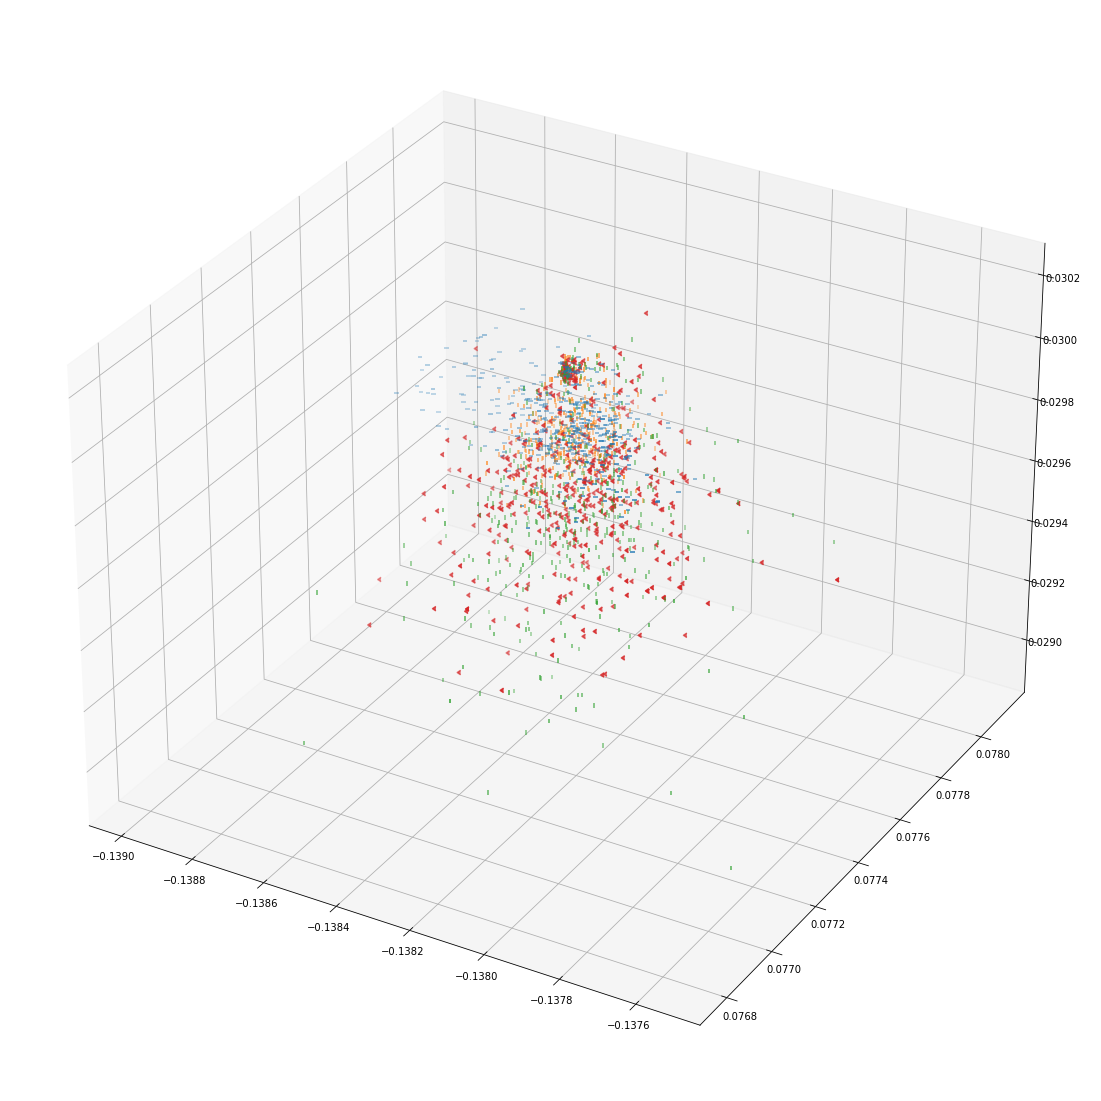

Epoch 1/30 successfull
Epoch 2/30 successfull


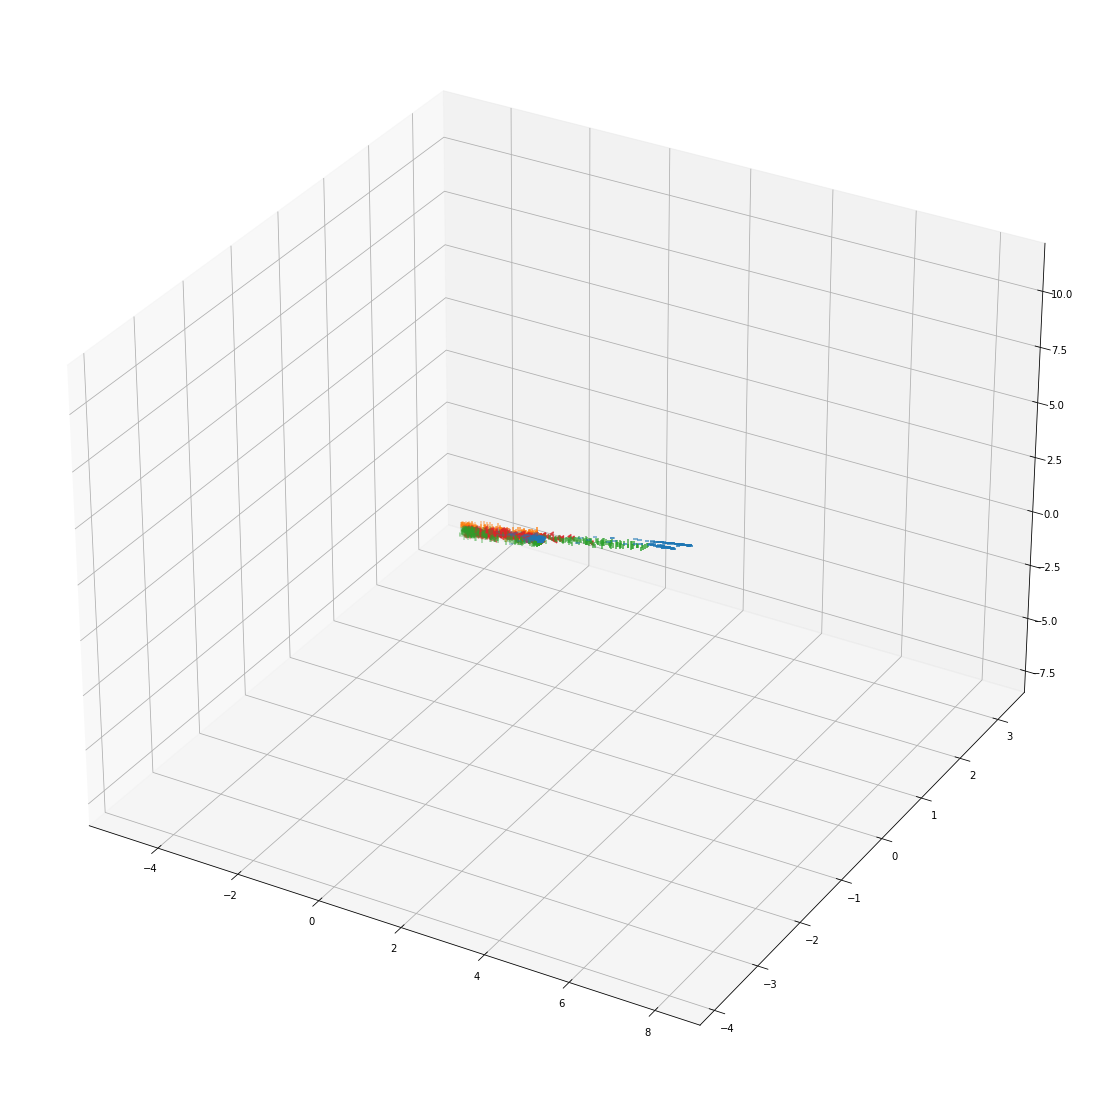

Epoch 3/30 successfull
Epoch 4/30 successfull


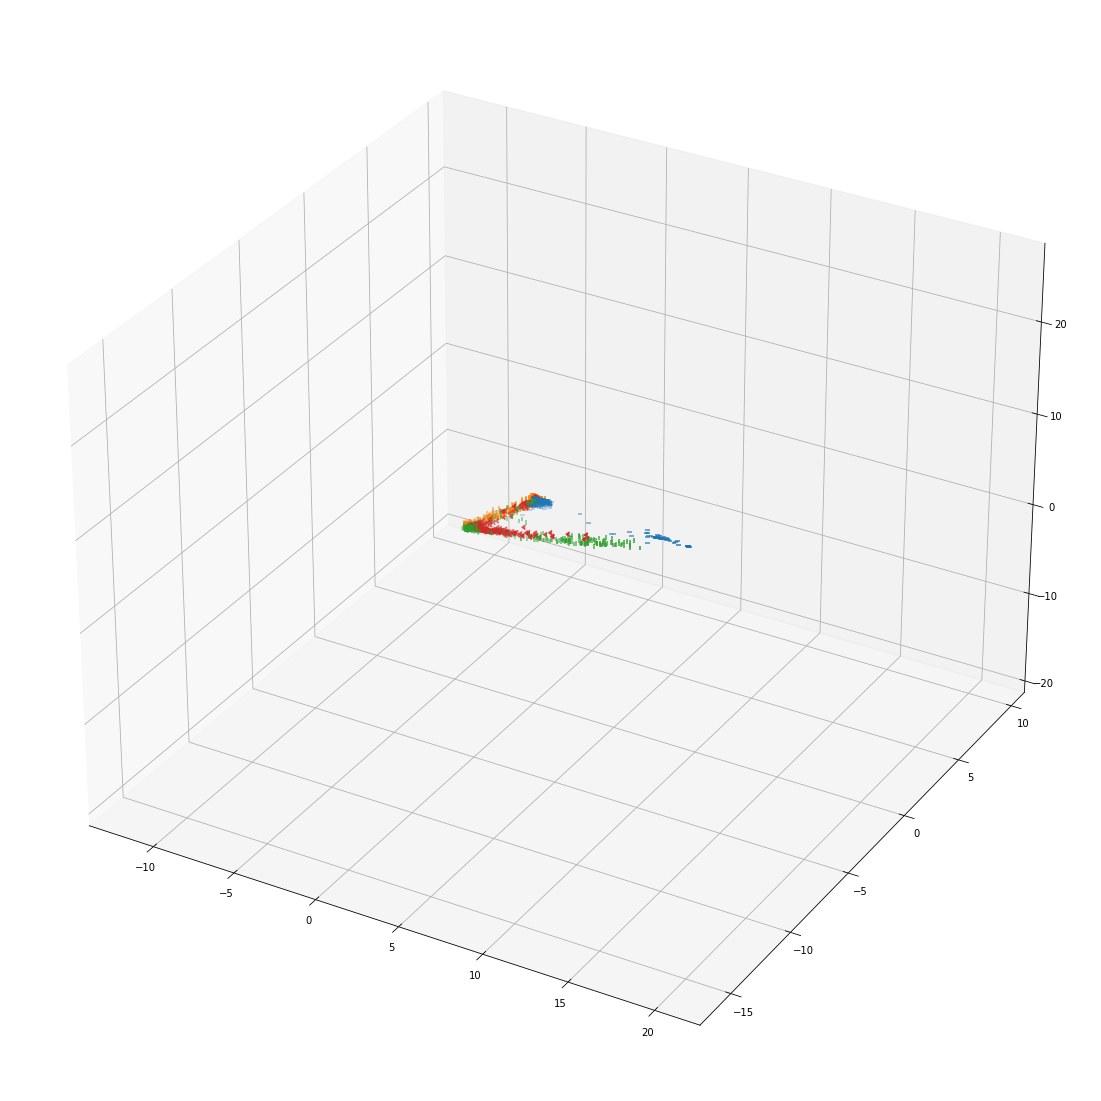

Epoch 5/30 successfull
Epoch 6/30 successfull


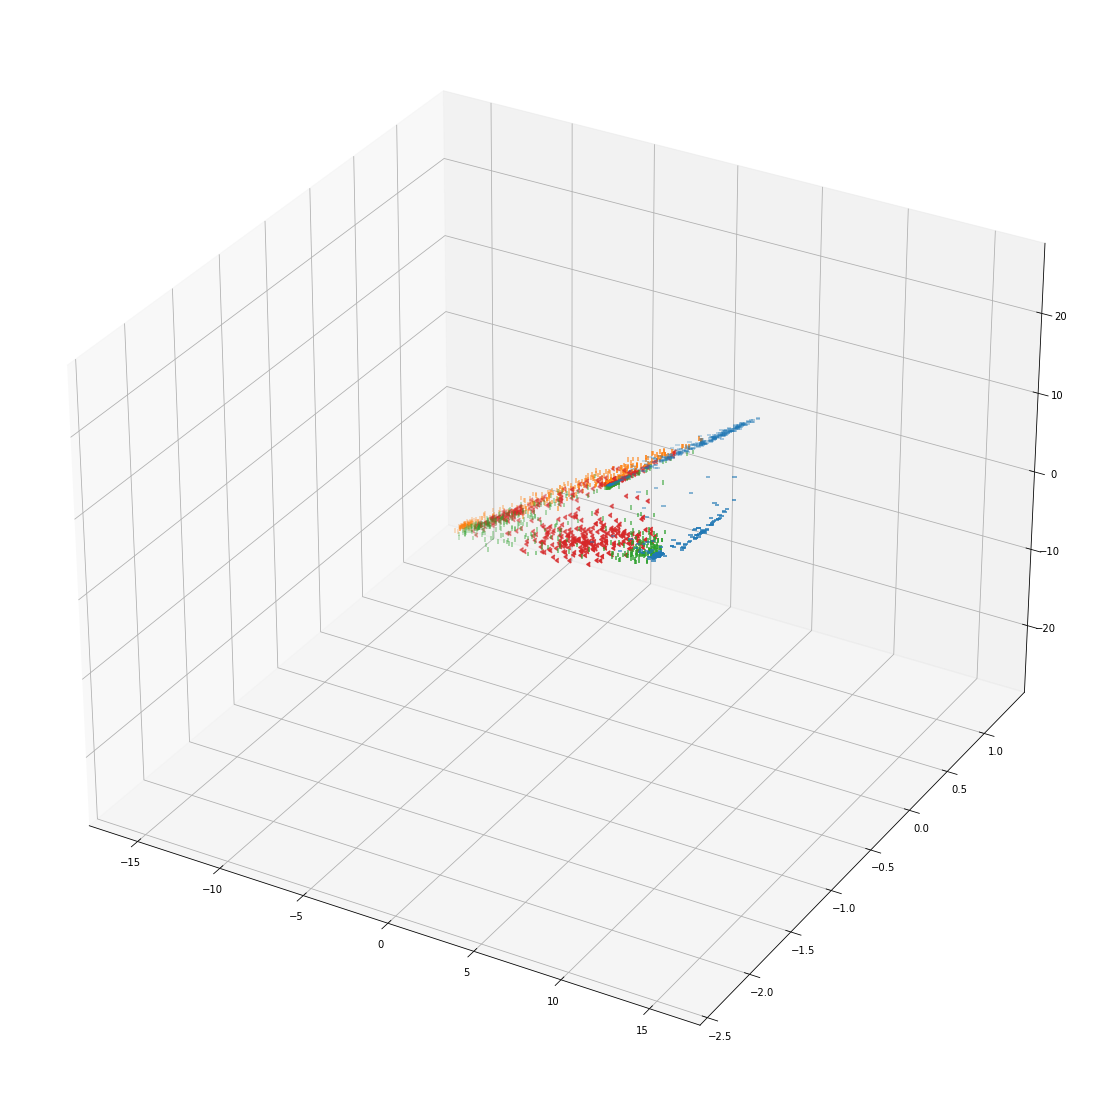

Epoch 7/30 successfull
Epoch 8/30 successfull
Epoch 9/30 successfull
Epoch 10/30 successfull
Epoch 11/30 successfull
Epoch 12/30 successfull
Epoch 13/30 successfull
Epoch 14/30 successfull
Epoch 15/30 successfull
Epoch 16/30 successfull
Epoch 17/30 successfull
Epoch 18/30 successfull
Epoch 19/30 successfull
Epoch 20/30 successfull
Epoch 21/30 successfull
Epoch 22/30 successfull
Epoch 23/30 successfull
Epoch 24/30 successfull
Epoch 25/30 successfull
Epoch 26/30 successfull
Epoch 27/30 successfull
Epoch 28/30 successfull
Epoch 29/30 successfull
Epoch 30/30 successfull


In [39]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_source_val = SummaryWriter('runs/Dataloader2/source_val')
writer_source_mmd = SummaryWriter('runs/Dataloader2/source_mmd')
writer_source_ce = SummaryWriter('runs/Dataloader2/source_ce')
writer_target_val = SummaryWriter('runs/Dataloader2/target_val')
writer_target_mmd = SummaryWriter('runs/Dataloader2/target_mmd')
writer_target_ce = SummaryWriter('runs/Dataloader2/target_ce')

writer_source = {}
writer_source["val"] = writer_source_val
writer_source["mmd"] = writer_source_mmd
writer_source["ce"] = writer_source_ce

writer_target = {}
writer_target["val"] = writer_target_val
writer_target["mmd"] = writer_target_mmd
writer_target["ce"] = writer_target_ce


#define training params
num_epochs = 30
GAMMA_inter_class = 100
GAMMA_intra_class = 100
SIGMA = torch.tensor([1,2,4,8,16],dtype=torch.float64)

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss_calculator = MMD_loss(fix_sigma = SIGMA)

optimizer1 = torch.optim.Adam([
{'params': model_cnn.parameters()},
{'params': model_fc.parameters(), 'lr': 1e-2}
], lr=1e-2, betas=(0.9, 0.999))

optimizer2 = torch.optim.Adam(model_fc.parameters(), lr=1e-2, betas=(0.9, 0.999))


#training iterations
phases = ["val", "mmd", "ce"]


#mmd_loss_flag
MMD_loss_flag_phase = {}
MMD_loss_flag_phase["val"] = True
MMD_loss_flag_phase["mmd"] = True
MMD_loss_flag_phase["ce"] = False


#init train data for each batch
loss_collected = 0
source_ce_loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
acc_total_source_collected = 0
acc_total_target_collected = 0

#plot lists
mmd_loss_list = {}
mmd_loss_list['val']=[]
mmd_loss_list['mmd']=[]
mmd_loss_list['ce'] = []

ce_loss_list_source = {}
ce_loss_list_source['val']=[]
ce_loss_list_source['mmd']=[]
ce_loss_list_source['ce'] = []

ce_loss_list_target = {}
ce_loss_list_target['val']=[]
ce_loss_list_target['mmd']=[]
ce_loss_list_target['ce'] = []

accuracy_list_source = {}
accuracy_list_source['val']=[]
accuracy_list_source['mmd']=[]
accuracy_list_source['ce'] = []

accuracy_list_target = {}
accuracy_list_target['val']=[]
accuracy_list_target['mmd']=[]
accuracy_list_target['ce'] = []

# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_out_collect = torch.empty((0,3))
    class_1_source_out_collect = torch.empty((0,3))
    class_0_target_out_collect = torch.empty((0,3))
    class_1_target_out_collect = torch.empty((0,3))

    
    for phase in phases:
        iter_loader_source = iter(source_loader[phase])
        iter_loader_target = iter(target_loader[phase])
        for i in range(len(iter_loader_source)):
            
            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows
            
            
            if phase == "val":
                
                #no training
                model_cnn.train(False)
                model_fc.train(False)
                
                
                with torch.no_grad():
                    _, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out = forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class)
                    # collect latent features for plot 
                    class_0_source_out_collect = torch.cat((class_0_source_out_collect, class_0_source_out), 0)
                    class_1_source_out_collect = torch.cat((class_1_source_out_collect, class_1_source_out), 0)
                    class_0_target_out_collect = torch.cat((class_0_target_out_collect, class_0_target_out), 0)
                    class_1_target_out_collect = torch.cat((class_1_target_out_collect, class_1_target_out), 0)
                    
                    
            
            elif phase == "mmd":
                
                #training
                model_cnn.train(True)
                model_fc.train(True)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer1.zero_grad()
                loss.backward()
                optimizer1.step()
                
            elif phase == "ce":
                
                #training
                model_cnn.train(True)
                model_fc.train(True)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA_inter_class, GAMMA_intra_class)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer2.zero_grad()
                loss.backward()
                optimizer2.step()
            
            # collect train data for each train phase
            mmd_loss_collected += mmd_loss
            source_ce_loss_collected += source_ce_loss
            target_ce_loss_collected += target_ce_loss
            acc_total_source_collected += acc_total_source
            acc_total_target_collected += acc_total_target
            
            
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_out_collect, class_1_source_out_collect, class_0_target_out_collect, class_1_target_out_collect]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i])
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}")            

        
        # Normalize collected train data for each train phase
        running_mmd_loss = mmd_loss_collected / len(source_loader[phase])
        
        running_acc_source = acc_total_source_collected / len(source_loader[phase])
        running_acc_target = acc_total_target_collected / len(target_loader[phase])
        
        running_source_ce_loss = source_ce_loss_collected / len(source_loader[phase])
        running_target_ce_loss = target_ce_loss_collected / len(target_loader[phase])
        
        
        #Add train data to plot list
        accuracy_list_source[phase].append(running_acc_source)
        accuracy_list_target[phase].append(running_acc_target)
        
        ce_loss_list_source[phase].append(running_source_ce_loss)
        ce_loss_list_target[phase].append(running_target_ce_loss)
        
        mmd_loss_list[phase].append(running_mmd_loss)


        #Add train data to tensorflow list
        writer_source[phase].add_scalar(f'accuracy', running_acc_source, epoch)
        writer_target[phase].add_scalar(f'accuracy', running_acc_target, epoch)
        
        writer_source[phase].add_scalar(f'ce_loss', running_source_ce_loss, epoch)
        writer_target[phase].add_scalar(f'ce_loss', running_target_ce_loss, epoch)
        
        writer_source[phase].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
        

        #reset train data for each batch
        loss_collected = 0
        source_ce_loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")

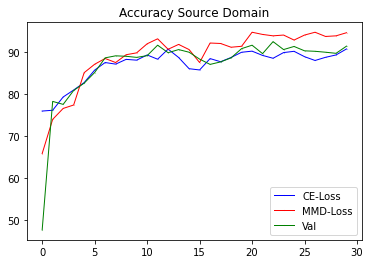

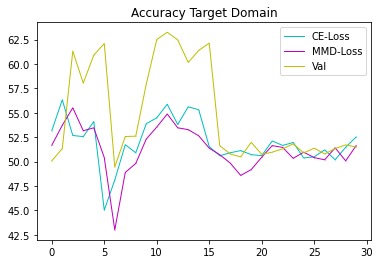

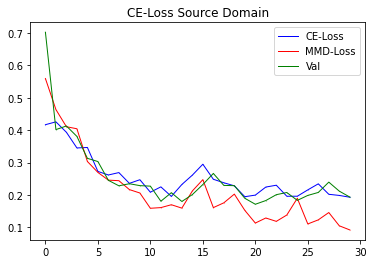

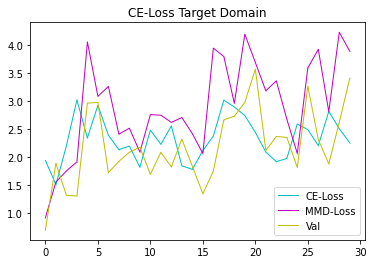

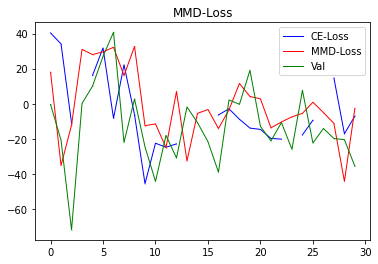

In [40]:
fig1 = plt.figure()
plt.title('Accuracy Source Domain')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy Source Domain')

fig2 = plt.figure()
plt.title('Accuracy Target Domain')
plt.plot(accuracy_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('Accuracy Target Domain')

fig3 = plt.figure()
plt.title('CE-Loss Source Domain')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('CE_Loss Source Domain')

fig4 = plt.figure()
plt.title('CE-Loss Target Domain')
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig4.savefig('CE_Loss Target Domain')

fig5 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig5.savefig('MMD_Loss')